In [1]:
using LinearAlgebra
using BenchmarkTools
using LaTeXStrings
using QuantumOptics
using Plots
using BenchmarkTools
using QuantumFCS

As a general scenario, we consider a Lindblad master equation denoted by,
$$ 
\mathcal{L}\rho =\frac{d \rho}{dt} = -i[H, \rho] + \sum_{k=1}^r L_k \rho L_k^\dagger -\frac{1}{2}\left\{L^\dagger_k L_k, \rho \right\}.
$$
From the above equation we introduce $p\leq r$ counting fields with weights $\nu_k$. This defines the generalized master equation (GME),
$$
\mathcal{L}_\chi \rho_\chi = \left(\mathcal{L} + \Delta \mathcal{L}_\chi \right)\rho_\chi,
$$
where,
$$
 \Delta \mathcal{L}_\chi = \sum_{k=1}^p(1-e^{i\nu_k \chi}) L_k \rho L_k^\dagger .
$$
Whatever method we use to compute the FCS, we start by vectorizating the GME,
$$
\mathcal{L}_\chi\rho_\chi \to   \mathcal{L}_\chi|\rho_\chi \rangle \rangle 
$$

Upon vectorization, the current fluctuations can be computed through

$$
\langle \langle I^n \rangle \rangle = \sum_{m=1}^n \binom{n}{m} \langle \langle 1| \mathcal{L}^{(m)}| \rho^{(n-m)}\rangle \rangle,
$$
where,
$$
| \rho^n\rangle \rangle = \mathcal{L}^+\sum_{m=1}^n \binom{n}{m}\left(  \langle \langle I^m \rangle \rangle - \mathcal{L}^{(m)}\right)|\rho^{(n-m)} \rangle \rangle
$$
and $|\rho^0\rangle \rangle := | \rho_{\rm ss}\rangle \rangle$.

In Julia vectors start at index 1. Therefore, it is more convenient to work with $| \sigma^{n+1} \rangle \rangle = | \rho^n\rangle \rangle$, which entail $| \sigma^{1} \rangle \rangle = | \rho^0\rangle \rangle$. We thus rewrite the above recursive formulas in terms of it


$$
\boxed{
\langle \langle I^n \rangle \rangle = \sum_{m=1}^n \binom{n}{m} \langle \langle 1| \mathcal{L}^{(m)}| \sigma^{(n+1-m)}\rangle \rangle,
}
$$
$$
\boxed{
| \sigma^n\rangle \rangle = \mathcal{L}^+\sum_{m=1}^{n-1} \binom{n-1}{m}\left( \langle \langle I^m \rangle \rangle - \mathcal{L}^{(m)}\right)|\sigma^{(n-m)} \rangle \rangle
}
$$


# Test for the Drazin inverse and Drazin apply

From melt.nb documentation, we have that a master equation of the form
$$ \mathcal{L} \rho = -i[\sigma_z,\rho]   + \gamma_m D[\sigma\rho + \gamma_p D[\sigma^\dagger]\rho.$$

The above Liouvillian has a corresponding Drazin inverse of the form,
$$\mathcal{L}^+ = \begin{pmatrix}
-\frac{\gamma_m}{(\gamma_m + \gamma_p)^2} & 0 & 0 & \frac{\gamma_p}{(\gamma_m + \gamma_p)^2}\\
0 & - \frac{2}{-4i + \gamma_m + \gamma_p} & 0 & 0\\
0 & 0 & - \frac{2}{+4i + \gamma_m + \gamma_p} & 0\\
\frac{\gamma_m}{(\gamma_m + \gamma_p)^2} & 0 & 0 & -\frac{\gamma_p}{(\gamma_m + \gamma_p)^2}
    \end{pmatrix}
$$

We now implement this analytical Drazin inverse and use it to test our function to compute the Drazin inverse.

In [2]:
qubit_drazin(γm, γp) = [-γm/(γm+γp)^2 0 0 γp/(γm+γp)^2; 0 -2/(-4im+γm+ γp) 0 0; 0 0 -2/(4im + γm + γp) 0; γm/(γm+ γp)^2 0 0 -γp/(γm + γp)^2]

b_s = SpinBasis(1//2)
σz = sigmaz(b_s)
σm = sigmam(b_s)
σp = sigmap(b_s)
γ = 1.0
γm = 0.5
γp = 0.1
LD_test = qubit_drazin(γm, γp)
J = [√γm*σm, √γp*σp]
L = liouvillian(σz, J)
ρss = steadystate.eigenvector(L)
l = length(ρss)
IdL = Matrix{ComplexF64}(I, l, l)
vId = vec(Matrix{ComplexF64}(I, size(ρss.data)))'
LD = drazin(σz, J, vec(ρss.data), vId, IdL)
display(round.(LD, digits=4))
println("Are these the same?")
isapprox(LD,LD_test, atol=1e-10)

4×4 Matrix{ComplexF64}:
 -1.3889+0.0im      0.0+0.0im        0.0+0.0im     0.2778+0.0im
    -0.0-0.0im  -0.0733-0.489im      0.0+0.0im        0.0-0.0im
     0.0+0.0im      0.0+0.0im    -0.0733+0.489im      0.0-0.0im
  1.3889-0.0im      0.0+0.0im        0.0+0.0im    -0.2778-0.0im

Are these the same?


true

# Two-level system 

In [5]:
b_s = SpinBasis(1//2)
σz = sigmaz(b_s)
σm = sigmam(b_s)
σp = sigmap(b_s)
γ = 1.0
nhf = 0.5
ncf = 0.1
ω = 1.0
H =  ω*σp*σm
J = √γ*[√(1-nhf)*σm, √(1-ncf)*σm, √nhf*σp, √ncf*σp]
# J = [√(γ*(1-nhf))*σm, √(γ*nhf)*σp]
mJ = [J[1], J[3]]
ρss = steadystate.eigenvector(H, J);

vss = vec(ρss.data)
vId = vec(one(b_s).data)'

# Let's make it recursive now!
# We always start by setting up the Drazin inverse, the vectorize jumpps:
Jop = m_jumps(mJ)
LD = drazin(H, J; rho_ss=ρss)
vρ0 = vss
# Then we compute the 1st vector and the 1st cumulant
vρ1 = Jop*vρ0
I1 =real(vId*vρ1)
# Then the 2nd vector and cumulant
I2 = real(vId*(m_jumps(mJ; n=2)*vρ0 - 2*m_jumps(mJ)*LD*vρ1))


println(I1)
println(I2)

MethodError: MethodError: no method matching drazin(::Operator{SpinBasis{1//2, Int64}, SpinBasis{1//2, Int64}, SparseArrays.SparseMatrixCSC{ComplexF64, Int64}}, ::Vector{Operator{SpinBasis{1//2, Int64}, SpinBasis{1//2, Int64}, SparseArrays.SparseMatrixCSC{ComplexF64, Int64}}}; rho_ss::Operator{SpinBasis{1//2, Int64}, SpinBasis{1//2, Int64}, Matrix{ComplexF64}})

Closest candidates are:
  drazin(::AbstractOperator, ::Any, !Matched::Vector{ComplexF64}, !Matched::Adjoint{ComplexF64, Vector{ComplexF64}}, !Matched::Matrix{ComplexF64}) got unsupported keyword argument "rho_ss"
   @ QuantumFCS ~/Library/CloudStorage/Dropbox/Work/Repos/QuantumFCS/src/FCS_functions.jl:71


In [3]:
K = fcscumulants_recursive(H, J, mJ, 2; rho_ss = ρss)
K_apply = fcscumulants_recursive(H, J, mJ, 2; rho_ss = ρss, apply = :true)
println("|_________Drazin________|")
println(K)
println("|_______Drazin_apply_____|")
println(K_apply)

UndefVarError: UndefVarError: `H` not defined

# Bosonic QHE

In [5]:
# Analytic expression I1 and I2  
function I1_bosonic_check(κ, g, nh, nc)
    2g^2*κ*(nh - nc)/(4g^2 + κ^2) 
 end    
     
 function I2_bosonic_check(κ, g, nh, nc)
    #  nT = nh + nc
    #  Δn = nh - nc
    #  I2 = (nT^2 + 2nT)*g^2*κ/(4g^2 + κ^2) - Δn^2*g^2*κ^3*(20*g^2 + κ^2)/(4g^2 + κ^2)^3
    mb = nc
    nb = nh
    I2 = (16*g^6*(mb + nb)*(2 + mb + nb)*κ + 4*g^4*(5*mb^2 - 2*mb*(nb-2) + nb*(4 + 5*nb))*κ^3 + 2*g^2*(mb + nb + 2*mb*nb)*κ^5)/(4*g^2 + κ^2)^3
    return I2
 end


b_fock = FockBasis(5)
ah = destroy(b_fock)⊗one(b_fock)
ahd = dagger(ah)
ac = one(b_fock)⊗destroy(b_fock)
acd = dagger(ac)

g = 1.0
κ = 1.0
nbh = 0.1
nbc = 0.0
H =  g*(ahd*ac + acd*ah)
J = [√(κ*(nbh+1))*ah, √(κ*(nbc+1))*ac, √(κ*nbh)*ahd, √(κ*nbc)*acd]
mJ = [J[2], J[4]]
ρss = steadystate.iterative(H, J);


ncum = 2
 K_apply = fcscumulants_recursive(H, J, mJ, ncum, ρss; apply = :true)
 K = fcscumulants_recursive(H, J, mJ, ncum, ρss)
println("|_________Drazin________|")
println(K)
println("|_______Drazin_apply_____|")
println(K_apply)
println("Fano")
println(K[2]/K[1])
I1_analytic = I1_bosonic_check(κ, g, nbh, nbc) 
I2_analytic = I2_bosonic_check(κ, g, nbh, nbc)
println("|________Analytic________|")
println([I1_analytic I2_analytic])
println("Fano")
println(I2_analytic/I1_analytic)


|_________Drazin________|


[0.039999796226715775, 0.042878823857731535]
|_______Drazin_apply_____|
[0.039999796226715775, 0.04287882385496807]
Fano
1.0719760574453343
|________Analytic________|


[0.04 0.04288]
Fano
1.072


In [48]:
grange = [0.01:0.01:5.01;]
κ = 1.0
nbh = 1.0
nbc = 0.0
I1dat = zeros(length(grange))
I2dat = zeros(length(grange))
I1check = zeros(length(grange))
I2check = zeros(length(grange))
for i=1:length(grange)
    g = grange[i]
    H =  g*(ahd*ac + acd*ah)
    J = [√(κ*(nbh+1))*ah, √(κ*(nbc+1))*ac, √(κ*nbh)*ahd, √(κ*nbc)*acd]
    mJ = [J[2], J[4]]
    ρss = steadystate.iterative(H, J);
    I1dat[i], I2dat[i] = fcscumulants_recursive(H, J, mJ, 2; rho_ss = ρss, apply = :true)
    I1check[i] = I1_bosonic_check(κ, g, nbh, nbc)
    I2check[i] = I2_bosonic_check(κ, g, nbh, nbc)
end

In [51]:
Fano = I2dat./I1dat
Fanocheck = I2check./I1check
;

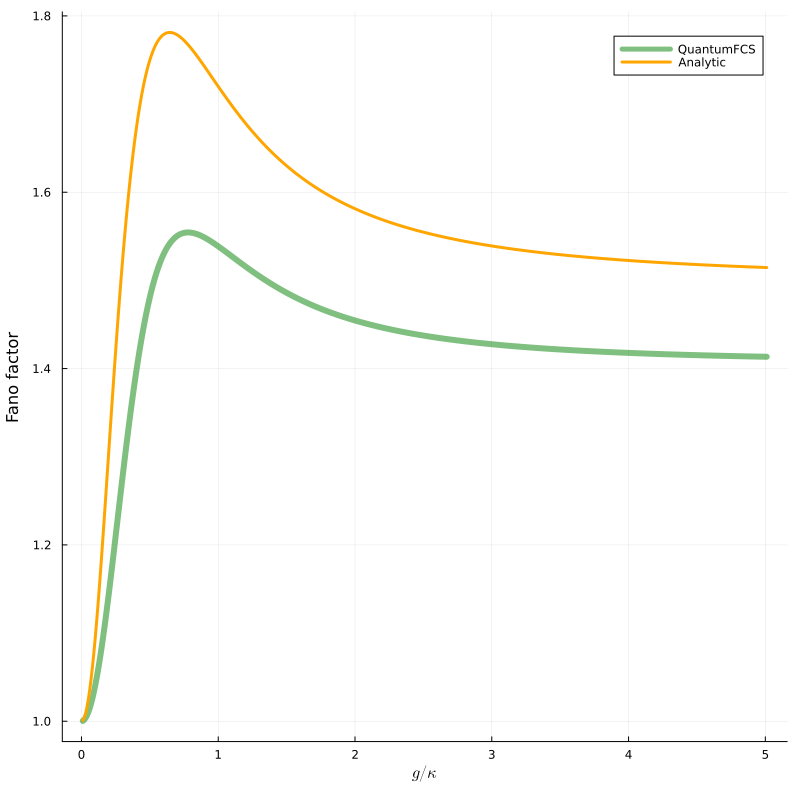

In [52]:
plot(grange, [Fano, Fanocheck], lw = [6 3], alpha = [0.5 1.0], c =[:green :orange], label = ["QuantumFCS" "Analytic"] )
plot!(xlabel =L"g/\kappa", ylabel ="Fano factor")
plot!(size = (800,800))

In [113]:
 g0 = 0.0001
 I2_bosonic_check(κ, g0, nbh, nbc)/I1_bosonic_check(κ, g0, nbh, nbc)

1.0500000059999997